In [1]:
import numpy
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib  import cm

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Times New Roman"]})
plt.rcParams["font.family"] = "Times New Roman"

## Generic functions

In [2]:
def add_labels(graph_title, x_label, y_label):
    """Add labels to graphs"""
    plt.title(graph_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

## Papers

[Identifying elastoplastic parameters with Bayes’ theorem considering output error, input error and model uncertainty](https://www.sciencedirect.com/science/article/pii/S0266892018300547)

[A Tutorial on Bayesian Inference to Identify Material Parameters in Solid Mechanics](https://link.springer.com/article/10.1007/s11831-018-09311-x)

## Parameters

A linear elastic-perfectly plastic specimen is considered with Young's modulus $E =$ 210 GPa and yield stress $\sigma_{y0} =$ 0.25 GPa. 

The parameters to be identified for the linear elastic-perfectly plastic model are the Young's modulus and the initial yield stress, which are stored in the parameter vector $\textbf{x}$:

 $$\textbf{x}=[E \; \sigma_{y0}]^T$$

In [3]:
E_correct = 210              # Young's modulus (GPa)
yield_stress_correct = 0.25  # Yield stress (GPa)
s_noise_correct = 0.01       # Noise in the stress measurement (GPa)

## Constitutive model

The stress-strain response of the linear elastic-perfectly plastic model during monotonic tension can be written as:

$$\sigma(\epsilon, \textbf{x}) = 
    \begin{cases}
        E\epsilon \quad \text{if} \quad \epsilon \leqslant \frac{\sigma_{y0}}{E} \\
        \sigma_{y0} \quad \text{if} \quad \epsilon > \frac{\sigma_{y0}}{E}
    \end{cases}$$

Using the Heaviside step function $h$, the stress-strain response of the linear elastic-perfectly plastic model can alternatively be expressed as:

$$\sigma(\epsilon, \textbf{x}) = E\epsilon\left(1 - h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right) + \sigma_{y0}h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)$$

Where $\textbf{x}$ is the parameter vector:

$$\textbf{x} = [E \; \sigma_{y0}]^T$$

$E$ is the Young's modulus and $\sigma_{y0}$ is the initial yield stress.

In [4]:
def calculate_stress(strain, yield_stress, E):
    yield_strain = yield_stress / E
    if strain < yield_strain:
        stress = E * strain
    elif strain > yield_strain:
        stress = yield_stress
    return stress

### Stress-strain graph

Twelve experimental measurements are provided. The noise in the stress measurements is a normal distribution with a zero mean and a standard deviation of $s_{noise}$.

In [5]:
def plot_stress_strain(strain_measured, stress_measured, yield_stress, E):
    
    strain = numpy.linspace(0, 2.5E-3, 100)
    stress = []

    for i in range(len(strain)):
        tmp = calculate_stress(strain[i], yield_stress, E)
        stress.append(tmp)
    
    plt.plot(strain, stress)
    plt.plot(strain_measured, stress_measured, 'o')
    add_labels("Stress-strain graph", "Strain $\epsilon$", "Stress $\sigma$")

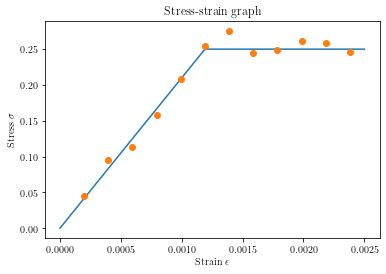

In [6]:
strain_experimental = [0.198E-3, 0.397E-3, 0.595E-3, 0.793E-3, 0.992E-3, 1.190E-3, 
                       1.388E-3, 1.587E-3, 1.785E-3, 1.985E-3, 2.182E-3, 2.383E-3]
stress_experimental = [0.0448, 0.0955, 0.113, 0.158, 0.209, 0.255, 
                       0.276, 0.244, 0.249, 0.262, 0.259, 0.246]
plot_stress_strain(strain_experimental, stress_experimental, yield_stress_correct, E_correct)

## Likelihood

$$\pi(y|\textbf{x}) = \frac{1}{s_{noise}\sqrt{2\pi}}exp\left(-{\frac{\left(y - E\epsilon\left(1 - h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right) - \sigma_{y0}h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right)^2}{2s^2_{noise}}}\right)$$

## Prior

$$\pi(\textbf{x}) = exp\left(-\frac{(\textbf{x}-\overline{\textbf{x}})^T\Gamma^{-1}(\textbf{x}-\overline{\textbf{x}})}{2} \right)$$

The following mean vector (prior candidate vector) and convariance matrix are selected:

$$\overline{\textbf{x}} = \begin{bmatrix} 200 \\ 0.29 \end{bmatrix} \; \text{GPa}, \quad \Gamma_\textbf{x} = \begin{bmatrix} 2500 & 0 \\ 0 & 2.7778 \times 10^{-4} \end{bmatrix} \; \text{GPa}^2$$

In [7]:
def calculate_prior(candidate_x, prior_x, cov_matrix):
    """Calculate the prior - note the exponential of the prior is taken
                             when calculating the posterior"""
    temp_var = candidate_x - prior_x
    inv_cov_matrix = numpy.linalg.inv(cov_matrix)
    numerator = numpy.matmul(numpy.transpose(temp_var), numpy.matmul(inv_cov_matrix, temp_var))
    prior = numerator / 2
    return prior

## Posterior

$$\pi(\textbf{x}|\textbf{y}) = exp\left(-\left(\frac{(\textbf{x}-\overline{\textbf{x}})^T\Gamma^{-1}(\textbf{x}-\overline{\textbf{x}})}{2} + {\frac{\Sigma_{i=1}^{n_m}\left(y_i - E\epsilon_i\left(1 - h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right) - \sigma_{y0}h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right)^2}{2s^2_{noise}}}\right)\right)$$

Where $n_m$ is the number of measurements, $y_i$ is the measured stress and $\epsilon_i$ is the measured strain.

In [8]:
def calculate_posterior(candidate_x, prior_x, cov_matrix,
                        strain_measured, stress_measured, s_noise):
        
    prior = calculate_prior(candidate_x, prior_x, cov_matrix)
    
    candidate_yield_stress = candidate_x[1]
    candidate_E = candidate_x[0]
    
    total = 0
    for i in range(len(stress_measured)):  # Loop over experimental data
        total += (stress_measured[i] - calculate_stress(strain_measured[i], candidate_yield_stress, candidate_E))**2
    
    posterior = numpy.exp(-(prior + (total / (2 * s_noise**2))))

    return posterior

## The standard Metropolis-Hastings algorithm

The standard Metropolis-Hastings approach is a frequently employed MCMC algorithm. The basic idea of the Metropolis-Hastings algorithm is to explore the probability density function (PDF) of interest by making a random walk through the parameter space $\textbf{x}$.

Consider sample $\textbf{x}_i$ and its evaluation of the PDF, $\pi(\textbf{x}_i)$ new sample $\textbf{x}_p$ is proposed by drawing from a proposal distribution.

$\gamma$ denotes the parameter that determines the width of the proposal distribution and must be tuned to obtain an efficient and converging algorithm. An efficient starting value is given by the following equation [1]:

$$\gamma = \frac{2.38}{\sqrt{n_p}}$$

Where $n_p$ denotes the number of unknown parameters.

[1] Gelman A, Roberts GO, Gilks WR (1996) Efficient Metropolis jumping rules. In: Bernardo JM, Berger JO, Dawid AP, Smith AFM (eds) Bayesian Statistics, vol 5. Oxford University Press, pp 599-607

In [9]:
def propose_new_sample(current_x):
    """Draw x (candidate) from proposal distribution"""
    
    gamma = 2.38 / numpy.sqrt(len(current_x))
    candidate_x = current_x + (gamma * numpy.transpose(numpy.random.normal(size=(1,2))))
    
    return candidate_x

In [10]:
def accept_or_reject_candidate(sample, current_x, candidate_x, pdf_candidate_x, pdf_current_x,
                               history_x, history_pdf):
    
    # Calculate the acceptance ratio (alpha) - alpha is used to decide whether to accept or reject a candidate
    alpha = min(1, pdf_candidate_x / pdf_current_x)

    # Generate a uniform random number (u)
    u = numpy.random.uniform(low=0.0, high=1.0)

    # Accept if u < alpha
    if u < alpha:
        history_x[sample, :] = numpy.transpose(candidate_x)
        current_x = candidate_x
        history_pdf[sample] = pdf_candidate_x

    # Reject if u > alpha
    if u > alpha:
        history_x[sample, :] = numpy.transpose(current_x)
        history_pdf[sample] = pdf_current_x
        
    return current_x, history_x, history_pdf

In [11]:
def metropolis_hastings(n_samples, initial_x, prior_cov_matrix, 
                        strain_measured, stress_measured, s_noise):
    
    # ----------------------------------------
    # Initial candidate
    # ----------------------------------------
    current_x = initial_x.copy()
    prior_x = initial_x.copy()
    
    history_pdf = numpy.zeros(n_samples)
    history_x = numpy.zeros([n_samples, 2])
    history_x[0, :] = numpy.transpose(current_x)
    
    
    for i in range(n_samples):
        
        # -----------------------------------------------
        # Draw a candidate from the proposal distribution
        # -----------------------------------------------
        
        candidate_x = propose_new_sample(current_x)

        # ------------------------
        # Calculate the likelihood
        # ------------------------
        
        pdf_current_x = calculate_posterior(current_x, prior_x, prior_cov_matrix, 
                                            strain_measured, stress_measured, s_noise)

        pdf_candidate_x = calculate_posterior(candidate_x, prior_x, prior_cov_matrix, 
                                              strain_measured, stress_measured, s_noise)
        
        # ------------------------------
        # Accept or reject the candidate
        # ------------------------------
        current_x, history_x, history_pdf = accept_or_reject_candidate(i, current_x, candidate_x, 
                                                                       pdf_candidate_x, pdf_current_x,
                                                                       history_x, history_pdf)
                
            
    return history_x, history_pdf

## Markov Chain Monte Carlo

Determine the PDF for the Young's modulus $E$ and yield stress $\sigma_{y0}$

In [12]:
n_samples = 100000
n_burnt_samples = 3000

initial_x = numpy.array([[200], [0.29]])  # Mean vector (GPa)
cov_matrix = numpy.array([[2500, 0], [0, 2.7778E-4]])  # Covariance matrix (GPa^2)

x, pdf = metropolis_hastings(n_samples, initial_x, cov_matrix,
                             strain_experimental, stress_experimental, s_noise_correct)


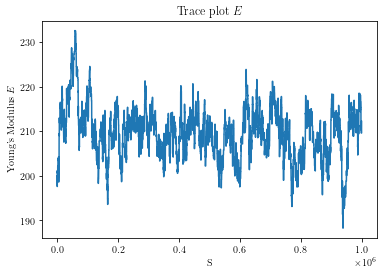

In [17]:
plt.plot(x[:,0])
add_labels("Trace plot \(E\)", "S", "Young's Modulus \(E\)")

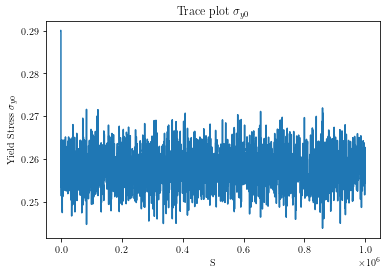

In [14]:
plt.plot(x[:,1])
add_labels("Trace plot \(\sigma_{y0}\)", "S", "Yield Stress \(\sigma_{y0}\)")

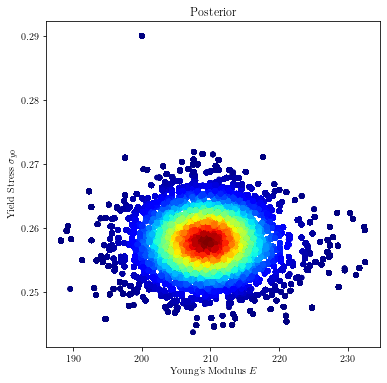

In [15]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(x[:,0], x[:,1], s=20, c=pdf, marker = 'o', cmap = cm.jet );
add_labels("Posterior", "Young's Modulus \(E\)", "Yield Stress \(\sigma_{y0}\)")

## The Adaptive Metropolis-Hastings algorithm


The width of the proposal distribution $\gamma$ has to be tuned to obtain an efficient and converging algorithm. It can be seen in the above figures that the chain converges on the correct yield stress $\sigma_{y0}$ but poor convergence behaviour is observed for the Young's modulus $E$. To overcome the tuning of $\gamma$, Haario et al. [2] introduced the adaptive proposal (AP) method. The AP method updates the width of the proposal distribution using the existing knowledge of the posterior. The existing knowledge is based on the previous samples.

For sample $n_k + 1$, the update employs the following formulation:

$$q(\textbf{x}_p | \textbf{x}_i) \sim N(\textbf{x}_i, \gamma^2 \textbf{R}_{n_{\textbf{k}}})$$

Where $N(\textbf{x}_i, \gamma^2 \textbf{R}_{n_{\textbf{k}}})$ denotes a normal distribution with mean $\textbf{x}_i$ and covariance matrix $\gamma^2 \textbf{R}_{n_{\textbf{k}}}$ of size $n_p \times n_p$. To establish $\textbf{R}_{n_{\textbf{k}}}$, all $n_k$ previous samples are first stored in matrix $\textbf{K}$ of size $n_{\textbf{K}} \times n_p$. $\textbf{R}_{n_{\textbf{k}}}$ is then computed as:

[2] Haario, H., Saksman, E., & Tamminen, J. (1999). Adaptive proposal distribution for random walk Metropolis algorithm. Computational Statistics, 14(3), 375-395.